In [1]:
import os
import numpy as np
from skimage.io import imread
import tensorflow as tf
import random
from skimage.transform import resize
from skimage.feature import hog
from skimage.color import rgb2gray
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# Parameters
image_folder = 'archive\shipsnet\shipsnet'
image_height, image_width = 128, 128  # Resize dimensions
num_classes = 2

In [3]:
# Set random seeds for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [4]:
# Load images and extract HOG features
def load_images_and_hog_features(folder):
    images, labels = [], []
    for filename in os.listdir(folder):
        if filename.startswith(('1', '0')):
            filepath = os.path.join(folder, filename)
            image = imread(filepath)
            image = resize(image, (image_height, image_width))
            gray_image = rgb2gray(image)
            hog_feature, _ = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
            images.append(hog_feature)
            labels.append(int(filename[0]))  # Assuming the class is the first character of the filename
    return np.array(images), np.array(labels)

In [5]:
images, labels = load_images_and_hog_features(image_folder)
labels = to_categorical(labels, num_classes=num_classes)

In [6]:
correct_hog_feature_size = images.shape[1]

In [7]:
# Update the model with more neurons
model = Sequential([
    Dense(4096, activation='relu', input_shape=(correct_hog_feature_size,)),
    Dropout(0.5),
    Dense(2048, activation='relu'),
    Dropout(0.4),
    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              2363392   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               5

In [9]:
# Split the data into training and testing sets
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:

# Train the model on the training set
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(images_train, labels_train, epochs=30, validation_split=0.2)

Epoch 1/30
80/80 [==============================] - 2s 15ms/step - loss: 0.5981 - accuracy: 0.7391 - val_loss: 0.5116 - val_accuracy: 0.7203
Epoch 2/30
80/80 [==============================] - 1s 12ms/step - loss: 0.4820 - accuracy: 0.7840 - val_loss: 0.4359 - val_accuracy: 0.7797
Epoch 3/30
80/80 [==============================] - 1s 12ms/step - loss: 0.3988 - accuracy: 0.8484 - val_loss: 0.4826 - val_accuracy: 0.7672
Epoch 4/30
80/80 [==============================] - 1s 13ms/step - loss: 0.3665 - accuracy: 0.8531 - val_loss: 0.3168 - val_accuracy: 0.8516
Epoch 5/30
80/80 [==============================] - 1s 13ms/step - loss: 0.4037 - accuracy: 0.8254 - val_loss: 0.3101 - val_accuracy: 0.8578
Epoch 6/30
80/80 [==============================] - 1s 12ms/step - loss: 0.4118 - accuracy: 0.8387 - val_loss: 0.3800 - val_accuracy: 0.8344
Epoch 7/30
80/80 [==============================] - 1s 12ms/step - loss: 0.4157 - accuracy: 0.8234 - val_loss: 0.2661 - val_accuracy: 0.9156
Epoch 8/30
80

In [11]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(images_test, labels_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

25/25 [==============================] - 0s 3ms/step - loss: 0.2266 - accuracy: 0.9212
Test Accuracy: 92.12%


In [12]:
# Predict on the test set
predictions = model.predict(images_test)

25/25 [==============================] - 0s 2ms/step


In [13]:
# Display some test images with their predicted labels
def display_images(images, labels, predictions, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"True: {np.argmax(labels[i])}, Pred: {np.argmax(predictions[i])}")
        plt.axis('off')
    plt.show()

In [17]:
# Load original images for display
def load_original_images(folder, indices):
    original_images = []
    filenames = sorted([f for f in os.listdir(folder) if f.startswith(('1', '0'))])
    for idx in indices:
        filepath = os.path.join(folder, filenames[idx])
        image = imread(filepath)
        image = resize(image, (image_height, image_width))
        original_images.append(image)
    return np.array(original_images)

In [42]:
# Get indices of test images
test_indices = np.random.choice(len(images_test), 10, replace=False)
original_test_images = load_original_images(image_folder, test_indices)

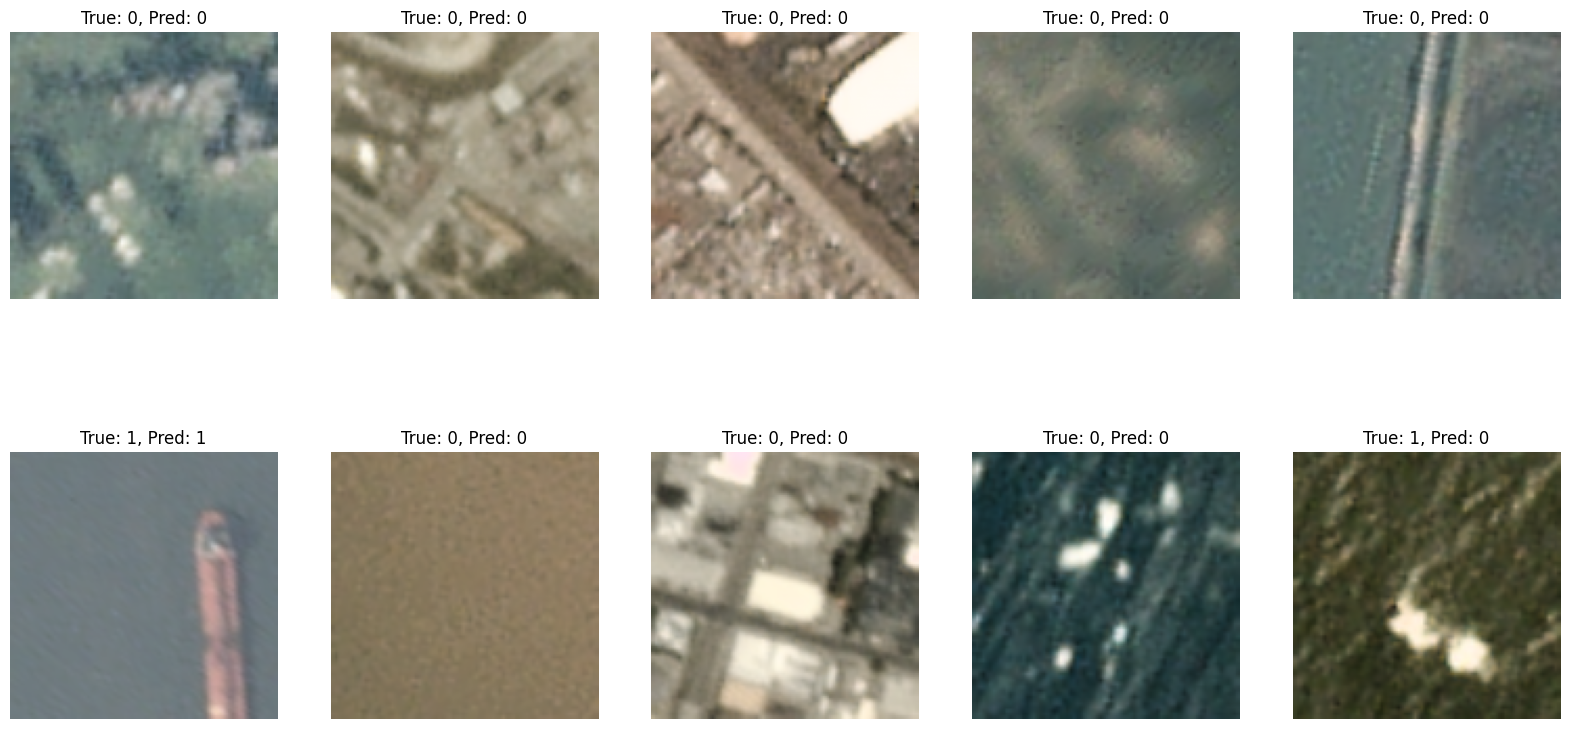

In [43]:
# Display the images
display_images(original_test_images, labels_test[test_indices], predictions[test_indices])

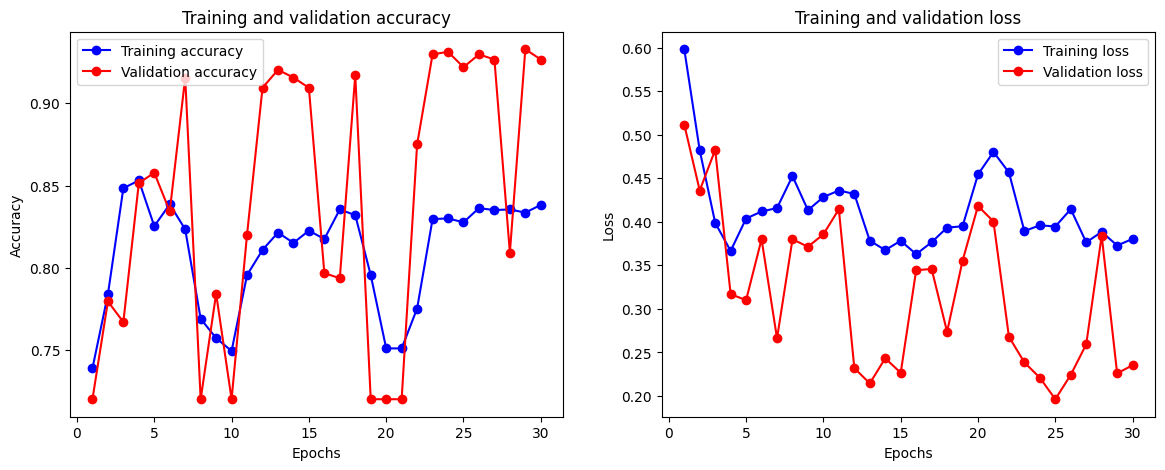

In [44]:
# Plot accuracy and loss curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the learning curves
plot_learning_curves(history)

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(images_test)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
report = classification_report(labels_test, predictions, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", report)

25/25 [==============================] - 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       616
     Class 1       0.92      0.72      0.81       184

   micro avg       0.92      0.92      0.92       800
   macro avg       0.92      0.85      0.88       800
weighted avg       0.92      0.92      0.92       800
 samples avg       0.92      0.92      0.92       800



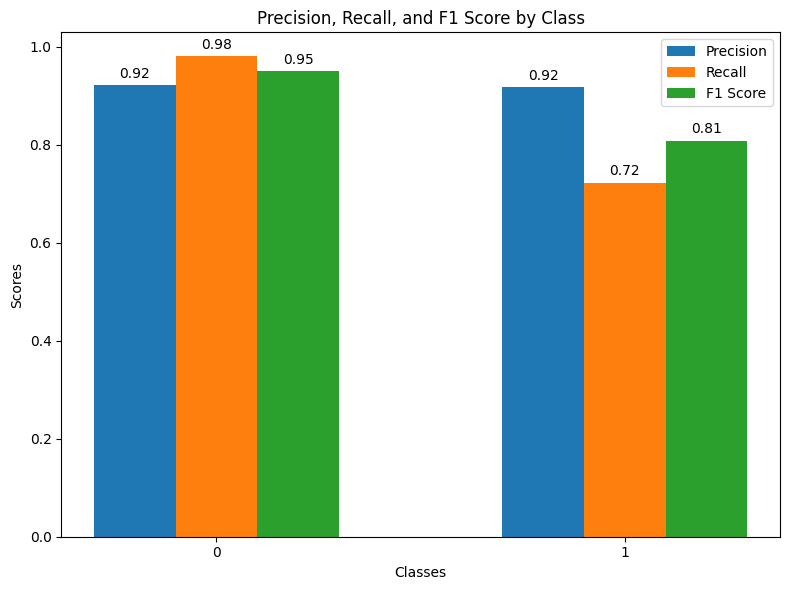

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming labels_test and predictions are one-hot encoded, convert them to single labels
labels_test_single = np.argmax(labels_test, axis=1)
predictions_single = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(labels_test_single, predictions_single, output_dict=True)

# Extract precision, recall, and f1-score for each class
classes = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

# Plot precision, recall, and f1-score
x = np.arange(len(classes))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1 Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# Attach a text label above each bar in rects, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()

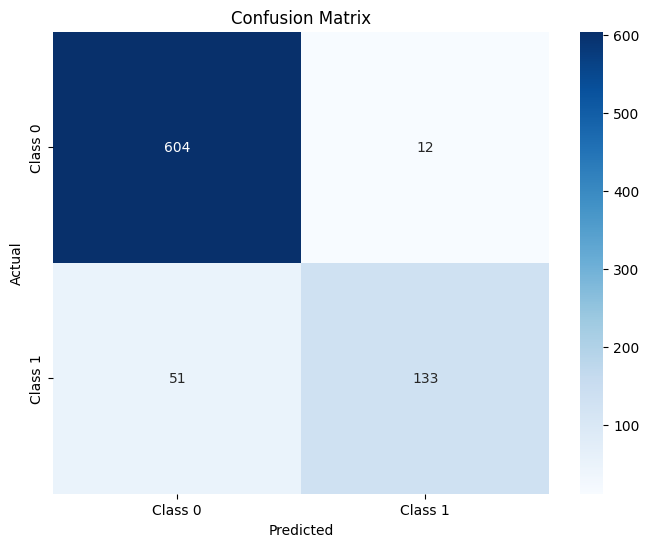

In [47]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming labels_test and predictions are one-hot encoded, convert them to single labels
labels_test_single = np.argmax(labels_test, axis=1)
predictions_single = np.argmax(predictions, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(labels_test_single, predictions_single)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()